# Análisis de Componentes Principales para Clasificación de Grupos de Comida con Base en su Información Nutrimental 

In [1]:
#Importanto librerías y scripts

import pandas as pd
import numpy as np
import sys
import os
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
sys.path.append('./../')

# OPTIONAL: In order to load data from Google Drive
#from google.colab import drive
#drive.mount('/content/gdrive') #Se da click en el URL que aparece y se ingresa la clave de autorización
#os.chdir('/content/gdrive/My Drive/Proyecto_Final_MNO')

# OPTIONAL: Load the "autoreload" extension so that code can change
%load_ext autoreload

#Own Library modules
import src

# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

from src.feature_selection import feature_selection as fs
from src.test_algorithms import comparaModelos


## Tabla de contenidos

1. [Introducción](#1.-Introducción)
2. [Datos y contexto](#2.-Datos-y-contexto)
3. [Análisis exploratorio de los datos](#3.-Análisis-exploratorio-de-los-datos)
4. [Teoría del Análisis de Componentes Principales](#4.-Teoría-del-Análisis-de-Componentes-Principales)
5. [Resultados del Análisis de Componentes Principales](#5.-Resultados-del-Análisis-de-Componentes-Principales)
6. [Análisis de conglomerados (clustering)](#6.-Análisis-de-conglomerados-(clusteing))
7. [Conclusiones](#7.-Conclusiones)
8. [Referencias](#8.-Referencias)

**Nota:** El siguiente reporte se corrió con una computadora con las siguientes especificaciones:

- **Sistema:** Windows 10

- **Procesador:** Core i7-7500U

- **Memoria RAM:**
    * Total: 8 GB

- **CPU**
    * Cores Físicos: 2
    * Cores Totales: 4

## 1.Introducción

El objetivo de este proyecto es implementar un método numérico aplicado a un problema real. En este caso el método numérico que se analiza es el de Análisis de Componentes Principales (PCA) con el método de SVD, algoritmo QR y método de la potencia. El problema de aplicación es intentar clasificar los grupos de comida con base en su información nutrimental habiendo quitado la multicolinealidad de la base. 

La base de datos consta de 45 variables y 8,618 observaciones. Sin embargo, es probable que algunas de estas variables estén correlacionadas entre sí derivando en un problema de multicolinealidad (Sharma, 1996). Si existe multicolinealidad, esto implica que el número de variables p no es realmente p si no m<p pues hay información repetida. Para solucionar este problema, puede ocuparse un método de reducción de dimensionalidad como PCA. De esta forma, se busca "extraer" la información más relevante de los datos conservando la variabilidad entre los mismos.

En el Análisis de Componentes Principales, se crean nuevas variables no correlacionadas que son combinaciones lineales de las variables originales. Así, se arregla la multicolinealidad de la información y se reduce la dimensionalidad de la matriz (Sharma, 1996).

Hay múltiples algoritmos que pueden implementarse para obtener los componentes principales. Ver, por ejemplo, [notas de clase](https://github.com/ITAM-DS/analisis-numerico-computo-cientifico/blob/master/temas/IV.optimizacion_convexa_y_machine_learning/4.3.Componentes_principales_Python.ipynb). 

En este proyecto, se utilizaron 4 métodos para obtener PCA: 1.la función SVD de `numpy`, 2. el algoritmo de QR, 3.el método de la potencia y 4. PCA de `scikit-learn`.

Una vez teniendo la implementación de los 4 métodos, se seleccionaron los componentes principales por sección que explicaran en conjunto el 80% de la varianza explicada de acuerdo con el criterio de varianza explicada y, como segundo criterio, que tuvieran un eigenvalor mayor a 1 en la matriz de correlación (Rencher & Christensen, 2012).

Finalmente, hizo un análisis de clasificación mediante K-means (ESCRIBIR MÁS)

## 2. Datos y contexto

Los datos se obtuvieron de un sitio de internet llamado [data.world](https://data.world/exercises/principal-components-exercise-1). Esta base fue trabajada por [Craig Kelly USDA](https://github.com/CraigKelly/nndb-import) basándose en la base de datos de [SR27 de la USDA National Nutrient Database](https://www.ars.usda.gov/northeast-area/beltsville-md-bhnrc/beltsville-human-nutrition-research-center/methods-and-application-of-food-composition-laboratory/mafcl-site-pages/sr11-sr28/) y complementándola con información sobre ingestas dietéticas de referencia: [Dietary Reference Intakes: The Essential Guide to Nutrient Requirements available from the National Academies Press](https://www.nap.edu/catalog/11537/dietary-reference-intakes-the-essential-guide-to-nutrient-requirements). 


La base de datos sobre composición alimenticia de la USDA National Nutrient Database for Standard Reference (SR) es la principal fuente de datos de composición de alimentos en los Estados Unidos. Contiene información sobre 8,618 tipos de comidas y 150 componentes de la comida. Esta es una bae de datos realcional con muchísima información, por lo tanto en la página también se publica una versión reducida de la base. La versión reducida se presenta en formato tabular y en Excel e incluye los mismos 8,618 tipos de comidas pero solamente se contiene 46 componentes de la comida o nutrientes. Esta base contiene información del año 2014.

Craig Kelly utilizó esta versión reducida de la base de la USDA y le agregó el porcentaje que cada nutriente de cada tipo de comida represent de la ingesta diaria recomendada por cada nuetriente según la guía mencionada más arriba, entre otras variables. La base de datos con la que se trabajó esta investigación es la de Craig Kelly. 

### 2.1 Datos

La base de datos de Craig Kelly contiene 8,618 observaciones que corresponden a un tipo de comida y 45 variables donde un gran porcentaje se refiere a los nutrientes de cada tipo de alimento y otro gran porcentaje se refiere al porcentaje de ingesta dietética de referencia para cada uno de estos nutrientes. Las demás variables son descriptivas del tipo de alimento. Esta base se llama `nndb_flat.csv` y puede encontrarse en [data](https://github.com/123972/PCA-nutricion/blob/master/data/nndb_flat.csv).

La infomación nutrimental de cada tipo de comida utiliza una porción de 100 gramos como referencia. 


A continuación, se describen brevemente las variables de las base y se clasifican con respecto a su tipo.

- Identificadores:
    - ID: Identificador para cada tipo de comida usando una porción de 100 gramos como referencia.
    
- Categóricas nominales:
    - Foodgroup: Categorías de los tipos de comida (25 categorías).
    - ShortDescrip: Pequeña descripción del tipo de comida.
    - Descrip: Descripción del tipo de comida.
    - CommonName: Nombre común de comida.
    - MfgName: Nombre de la marca del tipo de comida.
    - ScientificName: Nombre científico del tipo de comida.

- Numéricas continuas:
    - Energy_kcal: Energía calórica (kcal/100g).
    - Protein_g: Proteinas (g/100g).          
    - Fat_g: Grasas (g/100g).                
    - Carb_g: Carbohidratos (g/100g).              
    - Sugar_g: Azúcares totales (g/100g).            
    - Fiber_g: Fibras totales (g/100g)            
    - VitA_mcg: Vitamina A (mcg/100g).           
    - VitB6_mg: Vitamina B6 (mg/100g).           
    - VitB12_mcg: Vitamina B12 (mcg/100g).         
    - VitC_mg: Vitamina C (mg/100g).           
    - VitE_mg: Vitamina E (mg/100g).           
    - Folate_mcg: Ácido fólico (forma de vitamina B9) (mcg/100g).         
    - Niacin_mg: Niacina (forma de vitamina B3) (mg/100g).         
    - Riboflavin_mg: Riboflavina (vitamina B2) (mg/100g).       
    - Thiamin_mg: Tiamina (vitamina B1) (mg/100g).         
    - Calcium_mg: Calcio (mg/100g).          
    - Copper_mcg: Cobre (mcg/100g).        
    - Iron_mg: Hierro (mg/100g).               
    - Magnesium_mg: Magnesio (mg/100g).         
    - Manganese_mg: Manganeso (mg/100g).         
    - Phosphorus_mg: Fósforo (mg/100g).      
    - Selenium_mcg: Selenio (mineral) (mcg/100g).        
    - Zinc_mg: Zinc (mg/100g).            
    - VitA_USRDA: Porcentaje de vitamina A que contiene el alimento con respecto a la ingesta diaria recomendada (%).         
    - VitB6_USRDA: Porcentaje de vitamina B6 que contiene el alimento con respecto a la ingesta diaria recomendada (%).               
    - VitB12_USRDA: Porcentaje de vitamina B12 que contiene el alimento con respecto a la ingesta diaria recomendada (%).                   
    - VitC_USRDA: Porcentaje de vitamina C que contiene el alimento con respecto a la ingesta diaria recomendada (%).                      
    - VitE_USRDA: Porcentaje de vitamina E que contiene el alimento con respecto a la ingesta diaria recomendada (%).                    
    - Folate_USRDA: Porcentaje de vitamina A que contiene el alimento con respecto a la ingesta diaria recomendada (%).                   
    - Niacin_USRDA: Porcentaje de niacina que contiene el alimento con respecto a la ingesta diaria recomendada (%).                   
    - Riboflavin_USRDA: Porcentaje de riboflavina que contiene el alimento con respecto a la ingesta diaria recomendada (%).               
    - Thiamin_USRDA: Porcentaje de tiamina que contiene el alimento con respecto a la ingesta diaria recomendada (%).                 
    - Calcium_USRDA: Porcentaje de calcio que contiene el alimento con respecto a la ingesta diaria recomendada (%).                
    - Copper_USRDA: Porcentaje de cobre que contiene el alimento con respecto a la ingesta diaria recomendada (%).                 
    - Magnesium_USRDA: Porcentaje de magnesio que contiene el alimento con respecto a la ingesta diaria recomendada (%).              
    - Phosphorus_USRDA: Porcentaje de fósforo que contiene el alimento con respecto a la ingesta diaria recomendada (%).            
    - Selenium_USRDA: Porcentaje de selenio que contiene el alimento con respecto a la ingesta diaria recomendada (%).              
    - Zinc_USRDA: Porcentaje de zinc que contiene el alimento con respecto a la ingesta diaria recomendada (%).                
    
**NOTA:** g = gramos, mg = miligramos, mcg = microgramos, kcal = kilocalorías.

In [2]:
datos = pd.read_csv('../data/nndb_flat.csv')

In [3]:
datos.head()

,ID,FoodGroup,ShortDescrip,Descrip,CommonName,MfgName,ScientificName,Energy_kcal,Protein_g,Fat_g,...,Folate_USRDA,Niacin_USRDA,Riboflavin_USRDA,Thiamin_USRDA,Calcium_USRDA,Copper_USRDA,Magnesium_USRDA,Phosphorus_USRDA,Selenium_USRDA,Zinc_USRDA
0,1001,Dairy and Egg Products,"BUTTER,WITH SALT","Butter, salted",NaN,NaN,NaN,717,0.85,81.11,...,0.0075,0.002625,0.026154,0.004167,0.020000,0.000000,0.004762,0.034286,0.018182,0.008182
1,1002,Dairy and Egg Products,"BUTTER,WHIPPED,WITH SALT","Butter, whipped, with salt",NaN,NaN,NaN,717,0.85,81.11,...,0.0075,0.002625,0.026154,0.004167,0.020000,0.000018,0.004762,0.032857,0.018182,0.004545
2,1003,Dairy and Egg Products,"BUTTER OIL,ANHYDROUS","Butter oil, anhydrous",NaN,NaN,NaN,876,0.28,99.48,...,0.0000,0.000188,0.003846,0.000833,0.003333,0.000001,0.000000,0.004286,0.000000,0.000909
3,1004,Dairy and Egg Products,"CHEESE,BLUE","Cheese, blue",NaN,NaN,NaN,353,21.40,28.74,...,0.0900,0.063500,0.293846,0.024167,0.440000,0.000044,0.054762,0.552857,0.263636,0.241818
4,1005,Dairy and Egg Products,"CHEESE,BRICK","Cheese, brick",NaN,NaN,NaN,371,23.24,29.68,...,0.0500,0.007375,0.270000,0.011667,0.561667,0.000027,0.057143,0.644286,0.263636,0.236364


## 3. Análisis exploratorio de los datos

El análisis exporatorio de los datos se encuentra en :
[EDA_Datos_Limpiosv2.ipynb](https://github.com/123972/Final-Project-MNO-2020/blob/master/notebooks/EDA/EDA_Datos_Limpiosv2.ipynb) y consistió en lo siquiente:

1. Una evaluación de los valores únicos de cada variable para conocer el contenido de las mismas.
2. La realización de una matriz de correlación entre todas las variables numéricas para conocer cuáles variables está correlacionadas entre sí.
3. La realización de varios tipos de gráficas para tener una idea visual de la distribución de los datos y de las variabels más importantes.

**Nota:** Al ser muchos los macro y micro nutrientes, no se muestran todas las gráficas generadas en este reporte, sino, solamente, las que se consideró que eran más relevantes. 

### 3.1 Matriz de correlación y diagnóstico de multicolinealidad

In [4]:
#Borrando del dataset datos_limpios las variables no numéricas
numericas = datos.drop(columns=['ID','FoodGroup','ShortDescrip','Descrip','CommonName','MfgName','ScientificName'])

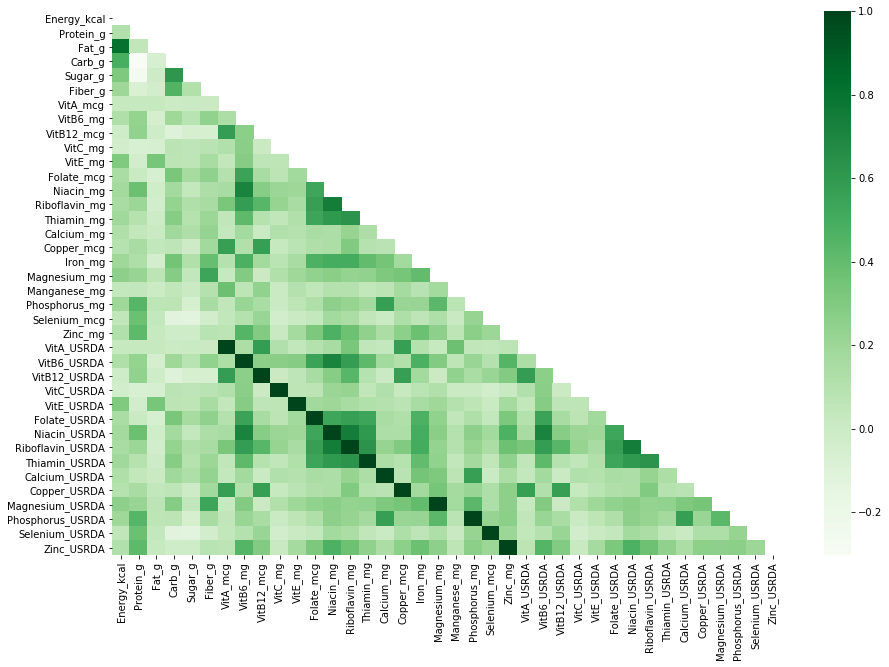

In [5]:
corr=numericas.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(15,10))
sns.heatmap(corr, mask=mask,cmap="Greens")

En la gráfica se puede ver una línea diagonal muy verde en donde la correlación es 1 para variables que no son sí misma. Es decir, existe multicolinealidad perfecta en esta base de datos. La multicolineadlidad perfecta surge dado que las variables que representan los porcentajes de ingesta calórica diaria fueron creadas con base en las variables de los nutrientes y por ende a mayor cantidad de nutriente, mayor porcentje representa. Es decir, se tiene información totalmente redundante en esta base que puede ser eliminada.

Además, también se observan altas correlaciones entre los nutrientes en sí, por ejemplo, entre la tiamina (vitamina b1), rivoflavina (vitamina B2), niacina (vitamina B3), la vitamina B6 y la vitamina B12. La razón puede deberse a que todas provienen del complejo B. También hay una fuerte correlación entre cobre y la vitamina A y C o las kilocalorías y las grasas y carbohidratos por ejemplo.

Para eliminar la multicolinealidad, se aplicará PCA a las variables numéricas que representan los macro y micro nuetrientes (no se incluirá a las variables de lor porcentajes de ingesta calórica dado la multicolinealidad perfecta).

### 3.2 Distribución de los macro y micro nutrientes

Para las gráficas siguientes, se borró la información redundante de la base de datos que se identificó en la sección anterior con la matriz de correlaciones.

In [6]:
#Borrando la información redundante del dataset
nutrientes = numericas.drop(columns=['VitA_USRDA','VitB6_USRDA' ,'VitB12_USRDA','VitC_USRDA','VitE_USRDA','Folate_USRDA','Niacin_USRDA','Riboflavin_USRDA','Thiamin_USRDA','Calcium_USRDA','Copper_USRDA','Magnesium_USRDA','Phosphorus_USRDA','Selenium_USRDA','Zinc_USRDA'])

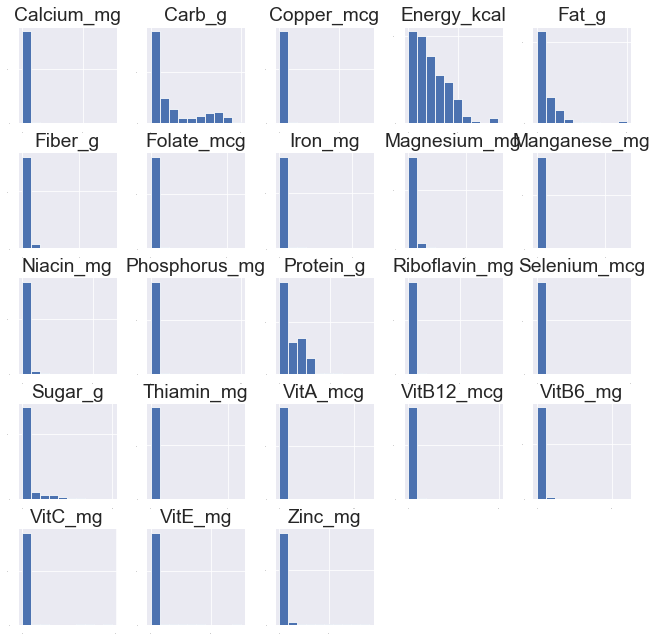

In [10]:
hist = nutrientes.hist(xlabelsize=-1, ylabelsize=-1, figsize=(11,11))

En esta imagen se muestran los histogramas de las 23 variables de macro y micro nutrientes. Como puede observarse, la mayoría de las distribuciones están sesgadas a la derecha. Eso se debe a que la mayoría de las comidas tienen un valor de 0 o cercano a 0 para los micronuetrientes.

### 3.2 Frecuencias por grupo de alimento

Text(0, 0.5, 'Grupo de alimento')

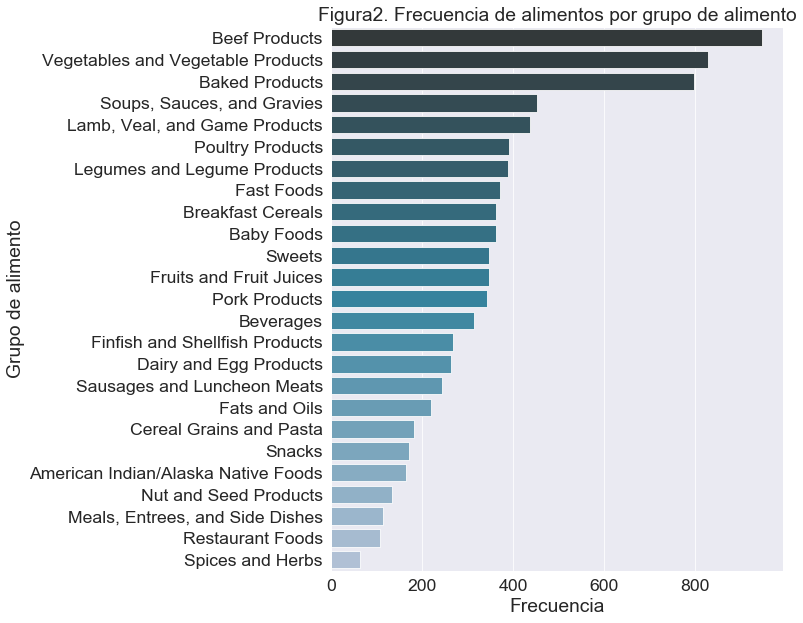

In [8]:
sns.set(style="darkgrid")
sns.set_context("paper", font_scale=2)     
plt.figure(figsize=(8.1, 10))
frecuencias = sns.countplot(y='FoodGroup', data=datos,order = datos['FoodGroup'].value_counts().index, palette='PuBuGn_d')
frecuencias.set_title('Figura2. Frecuencia de alimentos por grupo de alimento')
frecuencias.set_xlabel('Frecuencia')
frecuencias.set_ylabel('Grupo de alimento')

En esta figura se observan las frecuencias de las comidas por grupo de alimento. La mayoría de las comidas están clasificadas, en orden, como: productos de carne; vegetales y productos vegetales; productos horneados; sopas, salsas y gravies; cordero, ternera y productos de caza, entre otros.

Por otro lado, las comidas menos frecuentes son, en orden:

### 3.3 Distribución de los puntajes estandarizados de Matemáticas y Lenguaje y Comunicación por situación laboral

En la Figura 3 se encuentra, del lado izquierdo, la distribución de los puntajes estandarizados para la asignatura de Matemáticas por situación laboral y, del lado derecho, para la asignatura de Lenguaje y Comunicación. 

Se puede observar que los alumnos que trabajan tienen un menor desempeño en Matemáticas, pero un mejor rendimiento en Lenguaje y Comunicación y viceversa para los estudiantes que no trabajan.

### 3.4 Distribución de los puntajes estandarizados de Matemáticas por promedio escolar a nivel primaria, secundaria y bachillerato

En la Figura 4 se encuentran 3 gráficas de caja y brazos que muestran los puntajes estandarizados de la asignatura de Matemáticas contra el promedio escolar, en orden, de la primaria, secundaria y preparatoria.

En las 3 gráficas se observa un comportamiento monótono creciente conforme aumenta el promedio escolar. Este es un comportamiento esperado pues el promedio escolar puede ser un indicador de un buen estudiante. Además, se puede apreciar que el aumento en el puntaje es más pronunciado para los alumnnos con un promedio mayor a 8.5 en la primaria y secundaria y mayor a 8 en preparatoria. Finalmente, hay mayor disperión entre los alumnos con mayores promedios.

### 3.5 Distribución de los puntajes estandarizados de Lenguaje y Comunicación por promedio escolar a nivel primaria, secundaria y bachillerato

En la Figura 5 se encuentran nuevamente 3 gráficas de caja y brazos con el promedio escolar pero, esta vez, para la asignatura de Lenguaje y Comunicación.

De igual forma que con la Figura 4, se distingue una tendencia monótona creciente en los datos donde también parece haber una aceleración de la tendencia para los alumnos con promedios superiores a 8-8.5. En comparación con Matemáticas, pareciera haber mayor dispersión de los datos, especialmente para los promedios más bajos.

### 3.6 Distribución de los puntajes estandarizados de Matemáticas por nivel educativo de los padres

En la Figura 6 se observan dos gráficas de caja y brazos que muestran los puntajes estandarizados de la asignatura de Matemáticas contra el nivel educativo de la madre y padre del alumno. Esta variable es relevante pues normalmente, padre más educados son un ejemplo a seguir para los hijos y/o les exigen un poco más en los estudios. 

En las gráficas se aprecia que sí existe un ligero aumento en el puntaje en Matemáticas al tener la madre y padre un mayor nivel educativo. El efecto parece ser mayor para niveles es estudios superiores a la licenciatura. 

### 3.7 Distribución de los puntajes estandarizados de Lenguaje y Comunicación por nivel educativo de los padres

En la Figura 7 se encuentran nuevamente dos gráficas de caja y brazos con el nivel de escolaridad de los padres del alumnos pero, esta vez, para la asignatura de Lenguaje y Comunicación.

De igual forma que con la Figura 6, se distingue una ligera tendencia monótona creciente en los datos que se acelera a partir de un nivel de estudios superior a la carrera técnica. 

Dado que todas las variables de 
Para evaluar si habían problemas de multicolinealidad en los datos, se realizó una matriz de correlación incluyendo únicamente las variables numéricas.

## 4. Teoría del Análisis de Componentes Principales

### 4.1 Nociones básicas de PCA

El Análisis de Componentes Principales (PCA) es una técnica para crear nuevas variables que son combinaciones lineales de de las variabes originales. (Sharma, 1996). El objetivo principal es maximizar la varianza de las combinaciones lineales de tal forma que: el primer componente principal es la combinación lineal con máxima varianza, el segundo componente principal es la segunda combinación lineal con máxima varianza en dirección ortogonal a la primera componente y así sucesivamente (Rencher & Christensen,2012).

Este método es utilizado en diferentes situaciones: 1. cuando existe multicolinealidad en los datos, 2. como método de reducción de dimensionalidad, 3. para la construcción de índices, 4. cuando el número de variables explicativas es mayor que el número de observacinoes en regresión, entre otros.

#### 4.1.1 Enfoque geométrico

El enfoque geométrico de PCA se reduce, básicamente, a rotar los ejes para que se ajusten mejor a los datos, las variables estén no correlacionadas y se refleje la dirección de máxima varianza (Rencher & Christensen,2012). 

Lo primero que hay que notar es que si se hace una gráfica de las variables y éstas están correlacionadas entre sí, no se observará que la figura de puntos se encuentre paralela a ninguno de los ejes. Entonces, el objetivo es rotar los ejes de tal forma que que el origen sea el promedio de las variables y las nuevas variables estén no correlacionadas. En la siguiente figura se observa cómo los puntos formados por $y_1$ y $y_2$, que son las variabels originales (para la notación de este reporte serían $x_1$ y $x_2$), no se encuetran en línea con el eje $x$ y $y$. Por otro lado, al rotar los ejes y crear las nuevas variables $z_1$ y $z_2$, el ajuste de los datos es mejor. 

In [9]:
from IPython.display import Image, display
display(Image(filename='../docs/images/PCA_geo.png', embed=True))

FileNotFoundError: [Errno 2] No such file or directory: '../docs/images/PCA_geo.png'

\begin{aligned}
Fuente: Capitulo \space 12,\space Rencher \space y \space Christensen, \space 2012.
\end{aligned}
                
Para rotar los ejes, se debe multiplicar cada variable original $x_i$ por una matriz ortogonal $A$. De tal forma que: $z_i = Ax_i$.

La matriz $A$ que diagonaliza $S$ (la matriz de covarianzas de las $p$ variables originales $x_1, x_2, ... x_p$) es la matriz $C'$ (una matriz ortogonal compuesta por los eigenvectores normalizados de $S$). Esto proviene del teorema de Descomposición Espectral donde $C'SC = D = diag(\lambda_1,\lambda_2,...\lambda_p)$ y donde las $\lambda_i's$ son los eigenvalores de $S$. Entonces, 

\begin{aligned}
A = C' =\begin{pmatrix}
a'_1\\
a'_2\\
\vdots\\
a'_p
\end{pmatrix}
\end{aligned}

Y las $a_i's$ corresponden a los eigenvectores de $S$.

Los componentes principales $z_i's$ son simplemente la combinación lineal de los eigenvectores $a_i's$ de $S$ y las variables originales $x_i's$. Es decir,

\begin{aligned}
z_1 = a_{11}x_1+a_{12}x_2+...+a_{1p}x_p\\
z_2 = a_{21}x_1+a_{22}x_2+...+a_{2p}x_p\\
\vdots\\
z_p = a_{p1}x_1+a_{p2}x_2+...+a_{pp}x_p
\end{aligned}

#### 4.1.2 Enfoque algebraico

El enfoque algebraico se basa en el cálculo de los eigenvalores y eigenvectores de la matriz $S$. Para encontrar los eigenvalores y eigenvectores se resuelvese calculan de la siguiente forma:

\begin{aligned}
|S - \lambda_i I|a_i=0
\end{aligned}

El eigenvector $a_1$ que corresponde al eigenvalor más grande $\lambda_1$ es el vector de coeficientes $a_{11},a_{12},...,a_{1p}$ en $z_1 = a_{11}x_1+a_{12}x_2+...+a_{1p}x_p$. Como ya se mencionó anteriormente, este componente es la combinación lineal con varianza máxima.

Los coeficientes $a_{i1},a_{i2},...,a_{ip}$ pueden interpretarse como el peso que tiene cada variable original $x_i$ en el componente principal $z_i$ y ello ayuda a la interpretación pues se puede saber cuál variable está teniendo mayor peso en el componente.

Existe una relación entre los eigenvalores de la matriz $S$ y la "proporción de varianza total explicada" por los componentes. Los eigenvalores $(\lambda_1,\lambda_2,...\lambda_p)$ de $S$ son iguales a la varianza de los componentes principales $z_{1},z_{2},...,z_{p}$, de tal forma que:

\begin{aligned}
s^2_{z_i} = \lambda_i
\end{aligned}

Es decir, que se puede conocer el total de la varianza que explica cada componente y de esta forma, se puede elegir el número de componentes a conservar hasta que un umbral de varianza definidio sea explicado.

#### 4.1.3 Selección de componentes principales

Una vez calculados los componentes principales, hay que decidir cuántas y cuáles componentes conservar. Rencher y Christensen (2012) sugieren 4 métodos:

1. Retener suficientes componentes para explicar un porcentaje específico de la varianza total, por ejemplo 80%.
2. Retener los componente que tengan un eigenvalor mayor al promedio de los eigenvalores. Si  el cálculo de los eignvalores fue sobre la matriz de correlación $R$ en vez de la matriz de covarianzas $S$, retener los eigenvalores con un valor mayor a 1.
3. Usar la "gráfica scree" donde los eigenvalores se grafican en el eje y el número de componente al que corresponde cada eigenvalor en el eje x. Debe observarse una gráfica con un tipo de "codo". Se mantienen los eigenvalores que estén antes de la inflexión.
4. Hacer una prueba de significancia para los componentes más importantes, es decir los que corresponden a los eigenvalores más grandes.

En este trabajo se utilizó el primer criterio de varianza explicada a un 80% y el segundo criterio de eigenvalores mayores a 1.

### 4.2 Algoritmo SVD

El algoritmo de `PCA_from_SVD` tiene un enfoque de aproximación al algoritmo de PCA mediante la paquetería de `numpy`, que tiene una implementación del algoritmo de SVD. Para ello, inicialmente se centraron las observaciones de la matriz en cuestión restandole la media a cada una de las columnas.
 
Después, se aplicó el algoritmo de SVD y se extrajeron los siguientes elementos:
* Los valores singulares del método SVD sobre la matriz
* Los componentes del método SVD
* La varianza del mismo método
 
Una vez obtenidos dichos elementos, se calculó la varianza explicada como $A_t = \frac{S^2}{\sum_{i=0}^t S^2}$
Se obtuvieron los componentes principales $(Z)$ como la matriz centrada transpuesta por la matriz $V_t$, que es una matriz ortogonal.
 
Finalmente, de forma automática se calcula el número de componentes utilizando como criterio que la suma de componentes explique más del 60% de varianza, para regresarlo como un resultado de esta función.



#### 4.2.1 Programación y revisión del algoritmo SVD

La programación de este algoritmo puede encontrarse en [PCA_from_SVD.py](https://github.com/123972/Final-Project-MNO-2020/blob/master/src/pca/PCA_from_SVD.py) y el ejemplo de su implementación de uso en [PCA_from_SVD.ipynb](https://github.com/123972/Final-Project-MNO-2020/blob/master/notebooks/Programacion/PCA_from_SVD.ipynb).

### 4.3 Algoritmo QR

El algoritmo QR es un procedimiento para calcular los eigenvalores y eigenvectores de una matriz A. 

La idea básica es realizar una descomposición QR, esto es, factorizar la matriz $A$ como $A= QR$ donde $Q$ es una matriz ortogonal y $R$ es una matriz triangular superior, luego multiplicar los factores en orden inverso ($RQ$) e iterar.

#### 4.3.1 Programación y revisión del algoritmo QR

La programación de este algoritmo puede encontrarse en  [algoritmo_QR.py](https://github.com/123972/Final-Project-MNO-2020/blob/master/src/pca/algoritmo_QR.py) y en [PCA_from_QR.py](https://github.com/123972/Final-Project-MNO-2020/blob/master/src/pca/PCA_from_QR.py) y el ejemplo de su implementación de uso en [PCA_from_QR.ipynb](https://github.com/123972/Final-Project-MNO-2020/blob/master/notebooks/Programacion/PCA_from_QR.ipynb). 

Cabe mencionar que, con el fin de obtener PCA de la matriz de datos X, el algoritmo QR se aplicará a su matriz de covarianzas. 

La implementación del algoritmo consiste en:
- Declarar $A_0 = A$
- En el paso $k$ (empezando en $k=0$, hasta convergencia):
    - Obtener la factorización QR, $A_k=Q_kR_k$
    - Declarar $A_{k+1} = R_kQ_k$

Los eigenvalores se encontrarán en la diagonal de la matriz $A_k$, y si $A$ es simétrica (como lo es la matriz de covarianzas), las columnas de $Q$ (la composición de las transformaciones ortogonales aplicadas) serán los eigenvectores.



### 4.4 Método de la potencia

El método de la potencia

#### 4.4.1 Programación y revisión del método de la potencia

La programación de este algoritmo puede encontrarse en [PCA_from_potencia.py](https://github.com/123972/Final-Project-MNO-2020/blob/master/notebooks/src/pca/PCA_from_potencia.py) y el ejemplo de su implementación de uso en [PCA_from_potencia](https://github.com/123972/Final-Project-MNO-2020/blob/master/notebooks/Programacion/PCA_from_potencia.ipynb)

### 4.5 Algoritmo scikit-learn

La librería de `scikit-learn` ya trae programado el algoritmo para realizar PCA. En la documentación de este paquete se menciona que la reducción de dimensionalidad lineal usando la Descomposición de Valores Singulares (Singular Value Decomposition – SVD) de los datos ayuda para poderlos proyectar en un espacio dimensional más bajo. Los datos de entrada se centran, pero no se escalan para cada feature antes de aplicar SVD. El parámetro opcional **whiten = True** hace posible proyectar los datos en el espacio singular mientras se escala cada componente a la varianza unitaria. Esto con frecuencia es útil si los modelos en sentido descendente hacen suposiciones fuertes sobre la isotropía de la señal, esto es, por ejemplo, el caso de Máquinas de Soporte Vectorial con el **radial basis function kernel** (RBF kernel) y el algoritmo de clúster K-Means.

Esto utiliza la implementación de LAPACK de la SVD completa o una SVD truncada aleatoria por el método de [Halko et al. 2009](https://github.com/123972/Final-Project-MNO-2020/tree/master/docs/References), dependiendo de la forma de los datos de entrada y del número de componentes a extraer. También se puede usar la implementación de scipy.sparse.linalg ARPACK de la SVD truncada. Sin embargo, se debe cuidar que esta clase no admite entradas ralas, para ello se sugiere revisar el algoritmo [TruncatedSVD](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html#sklearn.decomposition.TruncatedSVD).

En scikit-learn, PCA se implementa como un objeto transformador que aprende $n$ componentes en su método **fit** (de ajuste) y puede utilizarse en nuevos datos para proyectarlo sobre estos componentes.

También uno de los objetivos de PCA es que proporciona una interpretación probabilística que puede dar una verosimilitud de los datos basada en la cantidad de varianza explicada.

#### 4.5.1 Programación y revisión del algoritmo scikit-learn

La programación de este algoritmo puede encontrarse en [PCA_from_sklearn.py](https://github.com/123972/Final-Project-MNO-2020/blob/master/src/pca/PCA_from_sklearn.py) y el ejemplo de su implementación de uso en [PCA_from_sklearn.ipynb](https://github.com/123972/Final-Project-MNO-2020/blob/master/notebooks/Programacion/PCA_from_sklearn.ipynb). 

## 5. Resultados del Análisis de Componentes Principales 
### 5.1 Comparación entre algoritmos

Como se ha planteado, aplicamos PCA con el fin de reducir la dimensionalidad de nuestro problema. Se decidió aplicar el análisis por secciones, para facilitar la interpretacion de los componentes principales resultantes al poder saber de qué sección proviene cada componente y cuáles preguntas se asocian a cada uno de ellos. Para algunas secciones (5,7,8 y 10) se escogieron subsecciones pues tenía más sentido dada las distribución de las preguntas. 

El análisis de PCA se realizó utilizando, por una parte, la función PCA del paquete `scikit learn`, y por otro, la implementación de varios algoritmos programados por el equipo: 
+ Utilizando la SVD con el paquete `numpy`
+ Programando el algoritmo QR 
+ Implementando el método de la potencia

A continuación, presentamos el resumen de las comparaciones realizadas entre los algoritmos propuestos y PCA de `scikit learn`. El análisis detallado puede encontrarse en [Comparativa PCA](https://github.com/123972/PCA-nutricion/blob/master/notebooks/Revision/Comparativa_PCA.ipynb).

#### 5.1.1 PCA de scikit learn vs PCA a partir de la SVD del paquete numpy

En primera instancia, comparamos los resultados obtenidos con PCA del paquete `scikit learn` contra el PCA obtenido a partir de la SVD calculada con el paquete `numpy`.

In [12]:
####Se estandarizan los datos.
scaler = preprocessing.StandardScaler()
df_nutrientes = scaler.fit_transform(nutrientes)

Como mostramos enseguida, en todos los casos obtuvimos la igualdad:

In [13]:
df_resultados_sk_np = comparaModelos.compara_resultados_abs_sk_np(df_nutrientes)
df_resultados_sk_np

,elemento,Igualdad (en valor absoluto),Max error relativo (con valor absoluto),Error relativo (con valor absoluto)
0,varianza explicada,True,1.935215e-16,"[0.0, 1.2189963581231018e-16, 1.57089176848327..."
1,valores singulares,True,0.000000e+00,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,coeficientes,True,0.000000e+00,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
3,componentes principales,True,1.128716e-10,"[[7.521729907317927e-15, 4.695376192208106e-15..."


Podemos observar que el mayor error relativo, que se presenta en las componentes principales fue del orden de $10^{-10}$.

#### 5.1.2 PCA de scikit learn vs PCA del algoritmo de QR

Posteriormente, comparamos los resultados iniciales de `scikit learn` con los obtenidos a partir del algoritmo QR.

Presentamos la comparación de resultados:

In [14]:
df_resultados_qr = comparaModelos.compara_resultados_abs_sk_qr(df_nutrientes)
df_resultados_qr

,elemento,Igualdad (en valor absoluto),Max error relativo (con valor absoluto),Error relativo (con valor absoluto)
0,varianza explicada,True,1.912542e-14,"[7.848981292888267e-15, 1.682214974209909e-14,..."
1,eigenvalores,True,2.441949e-14,"[3.259419297349506e-16, 2.4419493161683765e-14..."
2,coeficientes,True,5.478970e-08,"[[2.866773180195502e-14, 4.697647283337805e-14..."
3,componentes principales,True,3.882674e-05,"[[1.9991966332607923e-14, 2.3476880961041193e-..."


Una vez más, todos los elementos comparados fueron iguales. El mayor error relativo, que también ocurre en los componentes principales, es del orden de $10^{-5}$.

#### 5.1.3 PCA de scikit learn vs PCA del método de la potencia

### 5.2 Selección de componentes por el criterio de varianza explicada y eigenvalor

Como se explicó anteriormente, los dos criterios seguidos para la selección de componentes son: 1. el criterio de la proporción de la varianza explicada mayor a 80% y 2. el criterio de los eigenvalores mayores a 1.

En el notebook de [PCA_from_sklearn.ipynb](https://github.com/123972/Final-Project-MNO-2020/blob/master/notebooks/Programacion/PCA_from_sklearn.ipynb) se encuentra el procedimiento seguido para obtener los componentes principales de cada sección, así como sus respectivos eigenvalores y la proporción de la varianza explicada. El resumen de este proceso se encuentra en la tabla a continuación:

|  .......................................................................... |     Criterio de varianza explicada      |                   Criterio de eigenvalores        |
|:---------------------:|:------------------------:|:------------------:|


|              Sección             | No. de variables usadas en PCA | No. de componentes | % de varianza explicada | No. de componentes | % de varianza explicada |
|:--------------------------------:|:------------------------:|:------------------:|:-----------------------:|:------------------:|:-----------------------:|
|        1) Datos generales        |            11            |        3           |        63.86            |         3          |       63.86             |
|       2) Situación laboral       |            10            |        3           |        62.13            |         3          |       62.13             |
|    3) Expectativas educativas    |            5             |        2           |        71.54            |         2          |       71.54             |
|   4) Características personales  |            42            |        15          |        61.47            |         10         |       51.33             |
|            5.1) Inglés           |             4            |         1          |        74.73            |          1         |       74.73             |
|         5.2) Computación         |             4            |        2           |        78.48            |          1         |       59.24             |
| 6) Actividades extracurriculares |             2            |        2           |          100            |          1         |       57.69             |
|    7.1) Primaria y secundaria    |            16            |        7           |        66.01            |          7         |       66.01             |
|         7.2) Bachillerato        |            12            |        6           |        63.39            |          6         |       63.39             |
|       8.1) Entorno escolar       |             6            |        4           |        73.13            |          3         |       58.54             |
|     8.2) Maestros de español     |             5            |        2           |        72.71            |          1         |        59.39            |
|   8.3) Maestros de matemáticas   |            22            |        5           |        60.30            |          5         |        60.30            |
| 9) Características de la escuela |            20            |        4           |        61.31            |          3         |        56.59            |
|      10.1) Entorno familiar      |             9            |        4           |        69.53            |          3         |        59.66            |
|     10.2) Situación económica    |            14            |        5           |        62.19            |          4         |        55.83            |
|               Total              |            182           |        65          |                         |         53         |                         |

## 6. Análisis de conglomerados (clustering)

El análisis de conglomerados también se encuentra en el notebook [regresion_cluster.ipynb](https://github.com/123972/Final-Project-MNO-2020/blob/master/notebooks/Programacion/regresion_cluster.ipynb). Para éste, se utilizó el método de `K-Means` pero, esta vez se utilizaron todas las 182 variables que se emplearon para calcular los componentes principales utilizando el paquete `scikit-learn` y llamando a la función _componentes_principales_de _PCA_from_sklearn_. En dicho análisis, tanto el criterio del porcentaje de varianza explicada como el de eigenvalores, devolvieron un total de 51 componentes principales, es decir, se redujo la dimensionalidad a 51. 

Sin embargo, para el análisis de `K-Means`, únicamente se eligieron los 2 componentes más importantes. El primer componente se asocia a las preguntas 100, 107 y 99 que se refieren, respectivamente, a lo siguiente:

- ¿Con qué frecuencia tu(s) maestro(s) de matemáticas relaciona(n) tus conocimientos previos con los nuevos?
- ¿Con qué frecuencia tu(s) maestro(s) de matemáticas presenta(n) los temas de manera ordenada?
- ¿Con qué frecuencia tu(s) maestro(s) de matemáticas resuelve(n)  dudas  y preguntas en clase?

Y el segundo componente se asocia a las preguntas 138, 152 y 139 que se refieren, respectivamente, a lo siguiente:

- ¿Cuál es el nivel de estudios alcanzado por tu madre (contesta aunque ya haya fallecido)?
- Señala cuántas computadoras hay en tu casa.
- ¿Cuál es el nivel de estudios alcanzado por tu padre (contesta aunque ya haya fallecido)?

Por otra parte, para obtener el número de clusters óptimos se usó el método de `Elbow`. Se observa que el número óptimo de clusters a utilizar en el método de `K-Means` son 2 o 3 dado que, en esos puntos, se encuentra el punto de inflexión de la gráfica. No obstante, la ejecución de este proceso se demora, por lo que se decidió paralelizar usando `Dask`.

In [ ]:
from IPython.display import Image, display
display(Image(filename='../docs/images/cluster_optimos.png', embed=True))

### 6.1 Cómputo en paralelo usando Dask

Se utilizó la librería Dask que ayuda al procesamiento en sistemas de memoria compartida o distribuida para optimizar la ejecución del método de `K-Means`, tanto en la gráfica que muestra el número de clusters óptimos a utilizar, así como en el agrupamiento. A continuación se presenta el `client` que es el _entry point_ para users de dask.distributed.

In [ ]:
from IPython.display import Image, display
display(Image(filename='../docs/images/client.png', embed=True))

En la siguiente gráfica se muestra que ahora el número de clusters óptimos es 2. 

In [ ]:
from IPython.display import Image, display
display(Image(filename='../docs/images/cluster_optimos_paralelo.png', embed=True))

Por lo tanto se eligió un parámetro de k=2 que este es el número de grupos en los que se agrupan los datos. A continuación se presenta la gráfica de agrupamiento en donde también el método de `K-Means` se paralelizó.    

In [ ]:
from IPython.display import Image, display
display(Image(filename='../docs/images/k_means_paralelo.png', embed=True))

## 7. Conclusiones

## 8. Referencias

- Codesansar. (s.f). [Power Method Algorithm for Finding Dominant Eigen Value and Eigen Vector](https://www.codesansar.com/numerical-methods/power-method-algorithm-for-finding-dominant-eigen-value-and-eigen-vector.htm)
- Dan, D. J. (2014). [Power-Method-PCA](https://github.com/dianejdan/Power-Method-PCA/blob/master/power-pca.py)
- Data.world. (2017). [USDA National Nutrient DB](https://data.world/craigkelly/usda-national-nutrient-db)
- Equipo SVD. (2020). [Examen de cómputo matricial equipo SVD](https://github.com/mno-2020-gh-classroom/ex-modulo-3-comp-matricial-svd-czammar)
- Equipo QR. (2020). [Examen de cómputo matricial equipo QR](https://github.com/mno-2020-gh-classroom/ex-modulo-3-comp-matricial-qr-dapivei)
- QR algorithm, https://en.wikipedia.org/w/index.php?title=QR_algorithm&oldid=956468981 (consultada el 29 de mayo de 2020)
- Fox, J., Chalmers, P., Monette, G., & Sanchez, G. (2020). [PowerMethod: Power Method for Eigenvectors in matlib: Matrix Functions for Teaching and Learning Linear Algebra and Multivariate Statistics](https://rdrr.io/cran/matlib/man/powerMethod.html)
- Luhaniwal Vikashraj. (2019). ["Feature selection using Wrapper methods in Python"](https://towardsdatascience.com/feature-selection-using-wrapper-methods-in-python-f0d352b346f)
- Palacios M. Erick. (2020). Notas de MNO 2020. [SVD](https://github.com/ITAM-DS/analisis-numerico-computo-cientifico/blob/master/temas/III.computo_matricial/3.3.d.SVD.ipynb)
- Palacios M. Erick. (2020). Notas de MNO 2020. [Componentes principales](https://github.com/ITAM-DS/analisis-numerico-computo-cientifico/blob/master/temas/IV.optimizacion_convexa_y_machine_learning/4.3.Componentes_principales_Python.ipynb)
- Palacios M. Erick. (2020). Notas de MNO 2020. [Cómputo en paralelo - Dask](https://github.com/ITAM-DS/analisis-numerico-computo-cientifico/blob/master/temas/II.computo_paralelo/2.2.Python_dask.ipynb)
- Ramos, Irene. (2020). ["Tipología_manejo_agrícola"](https://github.com/iramosp/tesis-paisajes/blob/master/Tipologia_manejo_agricola.ipynb)
- Rencher, Alvin C & William F. Christensen. (2012). Methods of Multivariate Analysis. Department of Statistics, Brigham Young University, Provo, UT.- Third Edition. Ch 12.
- Sharma Subhash. (1996). Applied Multivariate Techniques. University of South Carolina. Ch4.
- U.S. Department of Agriculture, Agricultural Research Service. 2014. USDA National Nutrient Database for Standard Reference, Release 27. Methods and Application of Food Composition Laboratory Home Page, http://www.ars.usda.gov/nea/bhnrc/mafcl